# 第9章: RNN, CNN
## 80. ID番号への変換

問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ．

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2024-01-10 12:36:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [  <=>               ]  27.87M  91.5MB/s    in 0.3s    

2024-01-10 12:36:03 (91.5 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [5]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [7]:
text = train.iloc[1, train.columns.get_loc('TITLE')]
text

'Amazon Plans to Fight FTC Over Mobile-App Purchases'

In [8]:
train['TITLE'].iloc[1]

'Amazon Plans to Fight FTC Over Mobile-App Purchases'

In [9]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int) #辞書初期化
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('頻度上位20語')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

頻度上位20語
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


get():辞書オブジェクトのget()メソッドを使うと、キーが存在しない場合にエラーを発生させずに任意の値（デフォルト値）を取得できる。元の辞書は変更されない。

    print(d.get('key1'))
    # val1

    print(d.get('key5'))
    # None

    print(d.get('key5', 100))
    # 100

In [10]:
def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]

In [11]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


## 81. RNNによる予測
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．


$$
\overrightarrow h_0 = 0,\\
\overrightarrow h_t = {\rm \overrightarrow{RNN}}(\mathrm{emb}(x_t), \overrightarrow h_{t-1}), \\
y = {\rm softmax}(W^{(yh)} \overrightarrow h_T + b^{(y)})
$$


ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow h_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，${\rm \overrightarrow{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット${\rm \overrightarrow{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．

$$
{\rm \overrightarrow{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$

ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

RNNについて:
https://onl.la/ns3rwFX \
pytorch:RNNの使い方:https://atmarkit.itmedia.co.jp/ait/articles/2006/19/news023_2.html \
https://atmarkit.itmedia.co.jp/ait/articles/2002/06/news025.html \
https://ex-ture.com/blog/2021/01/12/pytorch-rnn/ \
隠れ層:https://onl.la/7J6nYfF

embedding:ある値に次元を埋め込むことが可能である。例えば1次元の0を5次元の[-0.5962, -1.2342,  1.1888, -1.1408, -0.3594]とすることができる。\
padding:Embeddingによる次元の変換を可能にするため足りないところにある値を補間する。padding_idxを用いると補間した値を無視してEmbeddingが可能である。

https://gotutiyan.hatenablog.com/entry/2020/09/02/200144

RNN:pytorch:https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

hidden:隠し層の状態\
hidden_size:隠し層のサイズ\
emb:Embedding後のtensor\
emb_size:Embedding調整のサイズ\
padding_idx:補間した値を無視してEmbedding\
nonlinerity:活性化関数\
batch_first:Trueの場合(batch, seq, feature)の形で出力\
fc:インスタンス変数\
Linerar:線形変換\
forward:\
out:\



In [12]:
import torch
import torch.nn as nn

vocab_size = 4
emb_dim = 5
embeddings = nn.Embedding(vocab_size, emb_dim)
# 0番目の単語なので，[0]をTensorに変換
word = torch.tensor([0,1,2,3])
embed_word = embeddings(word)
print(embed_word)
print(word.shape, '->', embed_word.shape)

tensor([[ 1.4142,  0.2895,  0.4887, -0.6298, -0.4997],
        [-0.6455,  0.2946,  1.2737, -0.2790,  1.3197],
        [ 0.1179, -1.0886, -1.2776, -0.2847,  0.1218],
        [-0.2031,  0.3032,  2.0572,  0.3279,  0.1112]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4]) -> torch.Size([4, 5])


In [13]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
    return hidden

In [14]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.iloc[index]
    inputs = self.tokenizer(text)

    return ({'inputs': torch.tensor(inputs, dtype=torch.int64),'labels': torch.tensor(self.y[index], dtype=torch.int64)})

In [15]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


unsqueeze():指定した位置にサイズ1の次元を挿入する。

    print(torch.unsqueeze(x, dim=0).size())
    # torch.Size([1, 2, 3, 4, 5, 6])

In [16]:
import torch
x = torch.zeros(2, 3, 4, 5, 6)
print(x.size())
print(x.unsqueeze(1).size())
print(x.size())
print(x.size()[0:2])

torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 1, 3, 4, 5, 6])
torch.Size([2, 3, 4, 5, 6])
torch.Size([2, 3])


In [17]:
m = nn.Softmax(dim=1)
input = torch.randn(2, 3)
output = m(input)
print(input)
print("\n")
print(output)


tensor([[2.0991, 0.1724, 0.5184],
        [0.5506, 0.6995, 0.9725]])


tensor([[0.7399, 0.1078, 0.1523],
        [0.2713, 0.3149, 0.4138]])


In [18]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs'] #titleのID表記したtensor
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeでバッチの大きさ1を追加

tensor([[0.1954, 0.2028, 0.2114, 0.3903]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3548, 0.1479, 0.2377, 0.2596]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2885, 0.2165, 0.2638, 0.2311]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1228, 0.2182, 0.2297, 0.4293]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2708, 0.2100, 0.2201, 0.2991]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1321, 0.3754, 0.2586, 0.2339]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2879, 0.3527, 0.1360, 0.2234]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3887, 0.3131, 0.1956, 0.1026]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3421, 0.2244, 0.2658, 0.1677]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3268, 0.2715, 0.2083, 0.1934]], grad_fn=<SoftmaxBackward0>)


## 82. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



DataLoader:DatasetCombines a dataset and a sampler, and provides an iterable over the given dataset.\
criterion():出力と訓練データの正解との誤差を求める\
torch.argmax:maxの値を出力\
scheduler:エポックに応じて学習率を変更する。\
scheduler説明:https://katsura-jp.hatenablog.com/entry/2019/01/30/183501#CosineAnnealingLR

In [19]:
a = torch.randn(4, 4)
print(a)
print("\n")
print(torch.argmax(a))

tensor([[ 0.2632,  0.7184, -0.1803, -0.6454],
        [ 0.3563,  0.3803,  0.8254,  1.1030],
        [ 0.2879,  0.1664,  0.0315, -0.1122],
        [ 1.8654,  0.0904,  1.8446,  2.5239]])


tensor(15)


In [20]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader: #バッチごとに取り出して処理
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [21]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

CrossEntropyLoss():https://qiita.com/ground0state/items/8933f9ef54d6cd005a69 \
torch.optim.SGD:https://pytorch.org/docs/stable/generated/torch.optim.SGD.html?highlight=optim+sgd#torch.optim.SGD


In [22]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1190, accuracy_train: 0.5012, loss_valid: 1.1334, accuracy_valid: 0.4948, 50.5334sec
epoch: 2, loss_train: 1.0440, accuracy_train: 0.5737, loss_valid: 1.0765, accuracy_valid: 0.5457, 51.3188sec
epoch: 3, loss_train: 0.9358, accuracy_train: 0.6407, loss_valid: 0.9989, accuracy_valid: 0.5996, 49.0090sec
epoch: 4, loss_train: 0.7741, accuracy_train: 0.7206, loss_valid: 0.8610, accuracy_valid: 0.6991, 48.1690sec
epoch: 5, loss_train: 0.6447, accuracy_train: 0.7733, loss_valid: 0.7567, accuracy_valid: 0.7358, 50.9728sec
epoch: 6, loss_train: 0.5709, accuracy_train: 0.7970, loss_valid: 0.7275, accuracy_valid: 0.7290, 50.2412sec
epoch: 7, loss_train: 0.5147, accuracy_train: 0.8159, loss_valid: 0.6887, accuracy_valid: 0.7440, 50.7759sec
epoch: 8, loss_train: 0.4775, accuracy_train: 0.8277, loss_valid: 0.6700, accuracy_valid: 0.7537, 52.4523sec
epoch: 9, loss_train: 0.4592, accuracy_train: 0.8327, loss_valid: 0.6612, accuracy_valid: 0.7620, 50.9309sec
epoch: 10, loss_tra

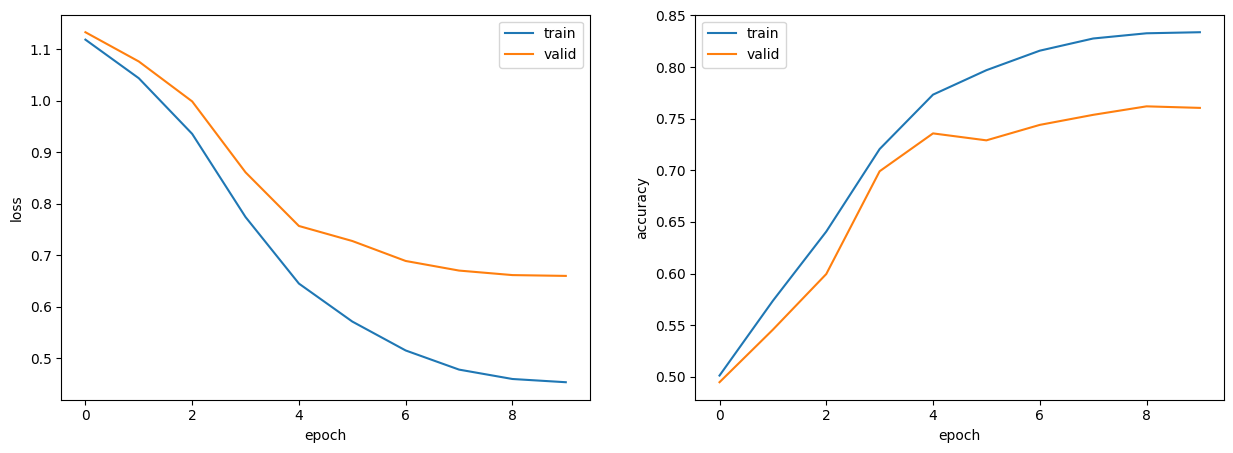

正解率（学習データ）：0.834
正解率（評価データ）：0.762


In [23]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 83. ミニバッチ化・GPU上での学習

問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．



In [24]:
import numpy as np
a = np.array([1,2,3,4,5])
print(a.shape[0])

5


In [25]:
a = torch.LongTensor([[2,1], [2, 3]])
print(a)
print(a.dtype)

tensor([[2, 1],
        [2, 3]])
torch.int64


In [26]:
class Padsequence():
  """Dataloaderからミニバッチを取り出すごとに最大系列長でパディング"""
  def __init__(self, padding_idx):
    self.padding_idx = padding_idx

  def __call__(self, batch):
    sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
    sequences = [x['inputs'] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=self.padding_idx) #最大系列長でpadding
    labels = torch.LongTensor([x['labels'] for x in sorted_batch])

    return {'inputs': sequences_padded, 'labels': labels}

In [27]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2535, accuracy_train: 0.4365, loss_valid: 1.2821, accuracy_valid: 0.4296, 10.8049sec
epoch: 2, loss_train: 1.1227, accuracy_train: 0.5515, loss_valid: 1.1750, accuracy_valid: 0.5172, 9.8485sec
epoch: 3, loss_train: 1.0616, accuracy_train: 0.6072, loss_valid: 1.1086, accuracy_valid: 0.5786, 9.3235sec
epoch: 4, loss_train: 1.0622, accuracy_train: 0.6067, loss_valid: 1.1239, accuracy_valid: 0.5734, 10.0794sec
epoch: 5, loss_train: 1.1449, accuracy_train: 0.5183, loss_valid: 1.2121, accuracy_valid: 0.4716, 10.1745sec
epoch: 6, loss_train: 1.1326, accuracy_train: 0.5302, loss_valid: 1.2087, accuracy_valid: 0.4978, 10.0587sec
epoch: 7, loss_train: 1.0966, accuracy_train: 0.5555, loss_valid: 1.1708, accuracy_valid: 0.5187, 10.6178sec
epoch: 8, loss_train: 1.0485, accuracy_train: 0.5917, loss_valid: 1.1296, accuracy_valid: 0.5434, 9.3338sec
epoch: 9, loss_train: 1.0078, accuracy_train: 0.6224, loss_valid: 1.0918, accuracy_valid: 0.5726, 10.0103sec
epoch: 10, loss_train:

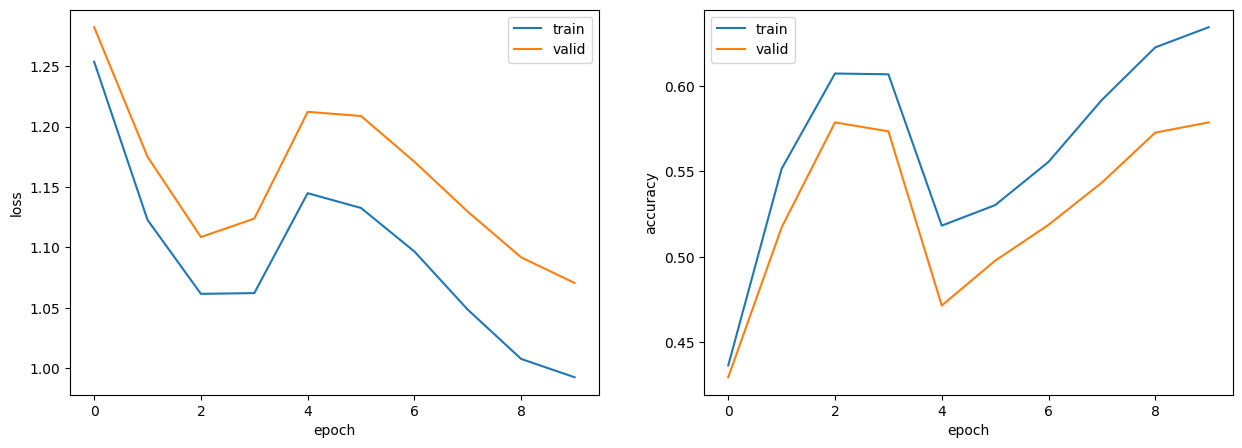

正解率（学習データ）：0.634
正解率（評価データ）：0.591


In [28]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での学習済み単語ベクトル）で単語埋め込み$emb(x)$を初期化し，学習せよ．


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('drive/MyDrive/自然言語処理/GoogleNews-vectors-negative300.bin.gz', binary=True)

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
  try:
    weights[i] = model[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 9174 / 9406
torch.Size([9406, 300])


In [31]:
class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, emb_weights=None, bidirectional=False):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2 bool型 False == 0 True == 1
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, nonlinearity='tanh', bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden(x.device)  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size * num_directions)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self, device):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size, device=device)
    return hidden

In [32]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1857, accuracy_train: 0.4011, loss_valid: 1.1902, accuracy_valid: 0.3900, 10.7758sec
epoch: 2, loss_train: 1.1729, accuracy_train: 0.4596, loss_valid: 1.2135, accuracy_valid: 0.4454, 9.9886sec
epoch: 3, loss_train: 1.0617, accuracy_train: 0.6052, loss_valid: 1.0735, accuracy_valid: 0.5898, 9.2906sec
epoch: 4, loss_train: 1.0271, accuracy_train: 0.6343, loss_valid: 1.0414, accuracy_valid: 0.6362, 10.2419sec
epoch: 5, loss_train: 1.2184, accuracy_train: 0.5125, loss_valid: 1.2728, accuracy_valid: 0.4888, 10.1338sec
epoch: 6, loss_train: 0.9884, accuracy_train: 0.6353, loss_valid: 1.0291, accuracy_valid: 0.6235, 9.2074sec
epoch: 7, loss_train: 0.9274, accuracy_train: 0.6615, loss_valid: 0.9725, accuracy_valid: 0.6519, 10.1846sec
epoch: 8, loss_train: 0.9427, accuracy_train: 0.6528, loss_valid: 0.9915, accuracy_valid: 0.6377, 10.2352sec
epoch: 9, loss_train: 0.9225, accuracy_train: 0.6612, loss_valid: 0.9755, accuracy_valid: 0.6475, 9.5425sec
epoch: 10, loss_train: 

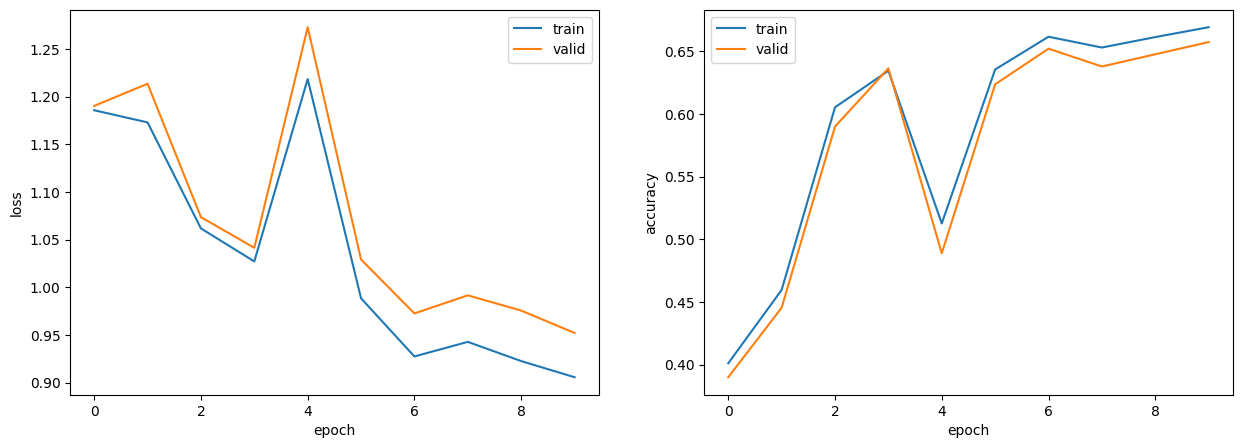

正解率（学習データ）：0.669
正解率（評価データ）：0.659


In [33]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．

$$
\overleftarrow h_{T+1} = 0, \\
\overleftarrow h_t = {\rm \overleftarrow{RNN}}(\mathrm{emb}(x_t), \overleftarrow h_{t+1}), \\
y = {\rm softmax}(W^{(yh)} [\overrightarrow h_T; \overleftarrow h_1] + b^{(y)})
$$

ただし，$\overrightarrow h_t \in \mathbb{R}^{d_h}, \overleftarrow h_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，${\rm \overleftarrow{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．


In [34]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights, bidirectional=True) #双方向

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.1371, accuracy_train: 0.4914, loss_valid: 1.1524, accuracy_valid: 0.4693, 10.7170sec
epoch: 2, loss_train: 1.1265, accuracy_train: 0.5387, loss_valid: 1.1533, accuracy_valid: 0.5277, 10.6421sec
epoch: 3, loss_train: 1.0573, accuracy_train: 0.5976, loss_valid: 1.1033, accuracy_valid: 0.5689, 12.2536sec
epoch: 4, loss_train: 0.9927, accuracy_train: 0.6350, loss_valid: 1.0309, accuracy_valid: 0.6235, 11.2205sec
epoch: 5, loss_train: 1.0932, accuracy_train: 0.5768, loss_valid: 1.1537, accuracy_valid: 0.5501, 11.1697sec
epoch: 6, loss_train: 0.9617, accuracy_train: 0.6457, loss_valid: 1.0091, accuracy_valid: 0.6295, 10.3940sec
epoch: 7, loss_train: 0.9414, accuracy_train: 0.6615, loss_valid: 0.9820, accuracy_valid: 0.6519, 10.9534sec
epoch: 8, loss_train: 0.9605, accuracy_train: 0.6463, loss_valid: 1.0063, accuracy_valid: 0.6325, 11.0697sec
epoch: 9, loss_train: 0.9899, accuracy_train: 0.6330, loss_valid: 1.0439, accuracy_valid: 0.6160, 11.1601sec
epoch: 10, loss_tra

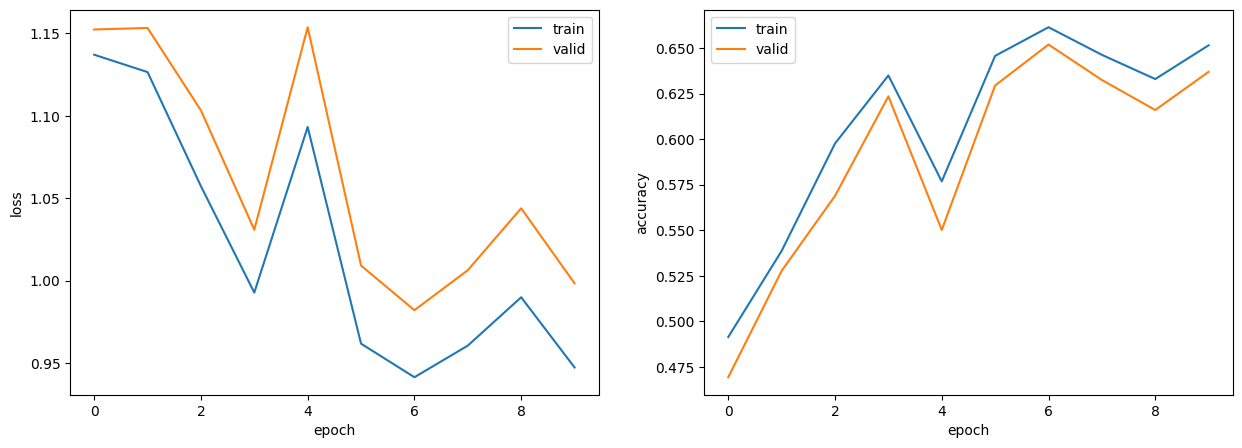

正解率（学習データ）：0.652
正解率（評価データ）：0.645


In [35]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 86. 畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列$\boldsymbol x = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol x$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．

+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現
 すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．

$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
]
$$

ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．
最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．

$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$

最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．

$$
y = {\rm softmax}(W^{(yc)} c + b^{(y)})
$$

なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

CNN:https://qiita.com/mathlive/items/8e1f9a8467fff8dfd03c

Conv2d:torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None) \
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2#torch.nn.Conv2d

Dropout:過学習を抑制する。\
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [36]:
m = nn.Dropout(0.3)
input = torch.randn(2, 10)
output = m(input)

print(output)

tensor([[-0.7036, -2.6148, -1.5951, -1.6444,  2.0666,  0.5710,  0.2091, -0.4041,
          0.2812, -0.9421],
        [-1.4106,  1.0417, -0.8046,  1.2227, -0.9965,  0.7305,  0.4278,  0.4449,
          0.0000,  0.0000]])


In [37]:
from torch.nn import functional as F

class CNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [38]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1)) #unsqueezeでbatch_sizeを1として追加

tensor([[0.2499, 0.2053, 0.2690, 0.2758]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2632, 0.2180, 0.2558, 0.2629]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2716, 0.2334, 0.2610, 0.2339]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2393, 0.2209, 0.2498, 0.2900]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2649, 0.2277, 0.2789, 0.2286]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2108, 0.2210, 0.2367, 0.3315]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2527, 0.2322, 0.2639, 0.2512]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1894, 0.2559, 0.2725, 0.2822]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2362, 0.2718, 0.2198, 0.2721]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2397, 0.2636, 0.2468, 0.2498]], grad_fn=<SoftmaxBackward0>)


## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ

In [39]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 64
NUM_EPOCHS = 10

# モデルの定義
model = CNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.0685, accuracy_train: 0.5691, loss_valid: 1.0787, accuracy_valid: 0.5808, 10.0971sec
epoch: 2, loss_train: 0.9866, accuracy_train: 0.6294, loss_valid: 1.0079, accuracy_valid: 0.6400, 8.9785sec
epoch: 3, loss_train: 0.9082, accuracy_train: 0.6915, loss_valid: 0.9449, accuracy_valid: 0.6871, 8.9704sec
epoch: 4, loss_train: 0.8474, accuracy_train: 0.7063, loss_valid: 0.8929, accuracy_valid: 0.6991, 9.4068sec
epoch: 5, loss_train: 0.8050, accuracy_train: 0.7247, loss_valid: 0.8673, accuracy_valid: 0.7096, 8.8523sec
epoch: 6, loss_train: 0.7731, accuracy_train: 0.7356, loss_valid: 0.8416, accuracy_valid: 0.7148, 9.1668sec
epoch: 7, loss_train: 0.7526, accuracy_train: 0.7406, loss_valid: 0.8265, accuracy_valid: 0.7223, 9.4332sec
epoch: 8, loss_train: 0.7405, accuracy_train: 0.7434, loss_valid: 0.8166, accuracy_valid: 0.7238, 8.5311sec
epoch: 9, loss_train: 0.7348, accuracy_train: 0.7455, loss_valid: 0.8129, accuracy_valid: 0.7260, 9.3391sec
epoch: 10, loss_train: 0.73

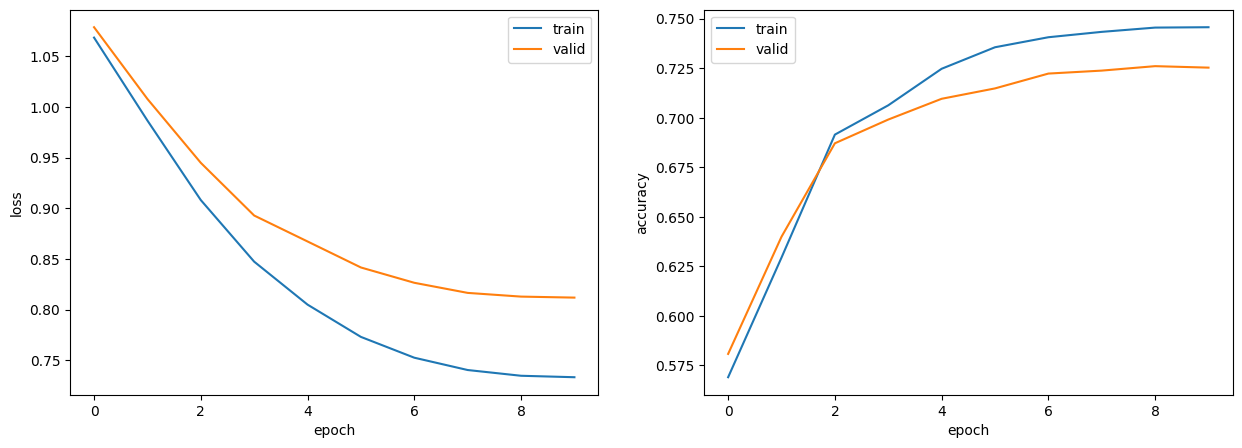

正解率（学習データ）：0.746
正解率（評価データ）：0.708


In [40]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

## 88. パラメータチューニング

問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

In [41]:
from torch.nn import functional as F

class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb).squeeze(3)) for conv in (self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [42]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [46]:
import optuna

def objective(trial):
  # チューニング対象パラメータのセット
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 300, 100))
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
  drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
  learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
  momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
  batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

  # 固定パラメータの設定
  VOCAB_SIZE = len(set(word2id.values())) + 1
  PADDING_IDX = len(set(word2id.values()))
  OUTPUT_SIZE = 4
  CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
  NUM_EPOCHS = 30

  # モデルの定義
  model = textCNN(VOCAB_SIZE, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, emb_weights=weights)

  # 損失関数の定義
  criterion = nn.CrossEntropyLoss()

  # オプティマイザの定義
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

  # デバイスの指定
  device = torch.cuda.set_device(0)

  # モデルの学習
  log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

  # 損失の算出
  loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)

  return loss_valid

In [47]:
# 最適化
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)



[I 2024-01-10 12:54:40,791] A new study created in memory with name: no-name-8d1a2434-ddf8-462c-9bca-503e27e844f7
<ipython-input-46-86b18a55ea06>:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 300, 100))
<ipython-input-46-86b18a55ea06>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-46-86b18a55ea06>:7: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...)

epoch: 1, loss_train: 1.0296, accuracy_train: 0.5797, loss_valid: 1.0517, accuracy_valid: 0.5973, 40.2475sec
epoch: 2, loss_train: 0.9104, accuracy_train: 0.6943, loss_valid: 0.9582, accuracy_valid: 0.6677, 39.5091sec
epoch: 3, loss_train: 0.7968, accuracy_train: 0.7273, loss_valid: 0.8655, accuracy_valid: 0.7066, 37.9964sec
epoch: 4, loss_train: 0.7139, accuracy_train: 0.7477, loss_valid: 0.8056, accuracy_valid: 0.7260, 37.2439sec
epoch: 5, loss_train: 0.6295, accuracy_train: 0.7825, loss_valid: 0.7575, accuracy_valid: 0.7410, 38.3057sec
epoch: 6, loss_train: 0.5617, accuracy_train: 0.8023, loss_valid: 0.7158, accuracy_valid: 0.7470, 37.4503sec
epoch: 7, loss_train: 0.4961, accuracy_train: 0.8340, loss_valid: 0.6776, accuracy_valid: 0.7627, 38.5465sec
epoch: 8, loss_train: 0.4382, accuracy_train: 0.8519, loss_valid: 0.6442, accuracy_valid: 0.7710, 38.9132sec
epoch: 9, loss_train: 0.3906, accuracy_train: 0.8754, loss_valid: 0.6205, accuracy_valid: 0.7829, 38.0761sec
epoch: 10, loss_tra

[I 2024-01-10 13:13:52,131] Trial 0 finished with value: 0.4956245667025988 and parameters: {'emb_size': 300.0, 'out_channels': 200.0, 'drop_rate': 0.4, 'learning_rate': 0.028346325117112343, 'momentum': 0.8, 'batch_size': 128.0}. Best is trial 0 with value: 0.4956245667025988.


In [48]:
# 結果の表示
print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
  print('    {}: {}'.format(key, value))

Best trial:
  Value: 0.496
  Params: 
    emb_size: 300.0
    out_channels: 200.0
    drop_rate: 0.4
    learning_rate: 0.028346325117112343
    momentum: 0.8
    batch_size: 128.0


--- 出力 ---\
Best trial:\
  Value: 0.469\
  Params: \
  emb_size: 300.0\
    out_channels: 100.0\
    drop_rate: 0.4\
    learning_rate: 0.013345934577557608\
    momentum: 0.8\
    batch_size: 32.0

In [49]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1
#EMB_SIZE = int(trial.params['emb_size'])
EMB_SIZE = 300;
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
#OUT_CHANNELS = int(trial.params['out_channels'])
OUT_CHANNELS = 100
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
#DROP_RATE = trial.params['drop_rate']
DROP_RATE = 0.4
#LEARNING_RATE = trial.params['learning_rate']
LEARNING_RATE = 0.013345934577557608
#BATCH_SIZE = int(trial.params['batch_size'])
BATCH_SIZE = 32
NUM_EPOCHS = 30

# モデルの定義
model = textCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE, emb_weights=weights)
print(model)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# デバイスの指定
device = torch.cuda.set_device(0)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

textCNN(
  (emb): Embedding(9406, 300, padding_idx=9405)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(2, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1), padding=(1, 0))
    (2): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1), padding=(2, 0))
  )
  (drop): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)
epoch: 1, loss_train: 0.8088, accuracy_train: 0.7129, loss_valid: 0.8923, accuracy_valid: 0.6759, 28.2471sec
epoch: 2, loss_train: 0.5785, accuracy_train: 0.7931, loss_valid: 0.7200, accuracy_valid: 0.7463, 27.9128sec
epoch: 3, loss_train: 0.4141, accuracy_train: 0.8524, loss_valid: 0.6304, accuracy_valid: 0.7732, 27.3751sec
epoch: 4, loss_train: 0.2754, accuracy_train: 0.9272, loss_valid: 0.5503, accuracy_valid: 0.8054, 27.5804sec
epoch: 5, loss_train: 0.1982, accuracy_train: 0.9580, loss_valid: 0.5437, accuracy_valid: 0.8031, 28.0801sec
epoch: 6, loss_train: 0.1432, accuracy_train: 0.9761, l

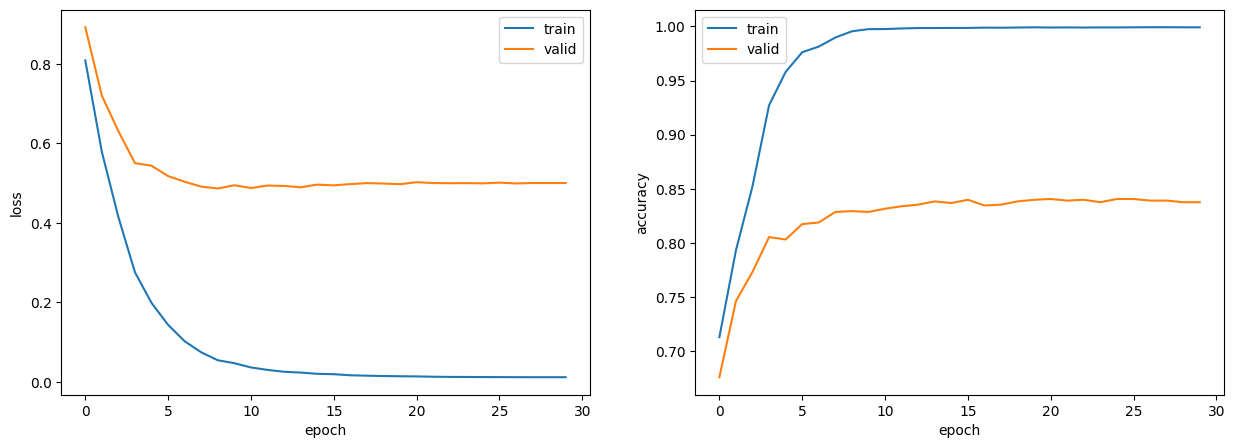

正解率（学習データ）：0.999
正解率（評価データ）：0.860


In [50]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

#89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えばBERTなど）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [51]:
!pip install transformers

In [52]:
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
import time
from matplotlib import pyplot as plt

In [53]:
# Datasetの定義
class NewsDataset(Dataset):
  def __init__(self, X, y, tokenizer, max_len):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X.iloc[index]
    inputs = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']

    return {
      'ids': torch.LongTensor(ids),
      'mask': torch.LongTensor(mask),
      'labels': torch.Tensor(self.y[index])
    }

In [54]:
# 正解ラベルのone-hot化
y_train = pd.get_dummies(train, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_valid = pd.get_dummies(valid, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values
y_test = pd.get_dummies(test, columns=['CATEGORY'])[['CATEGORY_b', 'CATEGORY_e', 'CATEGORY_t', 'CATEGORY_m']].values

# Datasetの作成
max_len = 20
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset_train = NewsDataset(train['TITLE'], y_train, tokenizer, max_len)
dataset_valid = NewsDataset(valid['TITLE'], y_valid, tokenizer, max_len)
dataset_test = NewsDataset(test['TITLE'], y_test, tokenizer, max_len)

for var in dataset_train[0]:
  print(f'{var}: {dataset_train[0][var]}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


ids: tensor([  101, 25416,  9463,  1011, 10651,  1015,  1011,  2647,  2482,  4341,
         2039,  2005,  4369,  3204,  2004, 18730,  8980,   102,     0,     0])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
labels: tensor([1., 0., 0., 0.])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [55]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
  def __init__(self, drop_rate, otuput_size):
    super().__init__()
    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.drop = torch.nn.Dropout(drop_rate)
    self.fc = torch.nn.Linear(768, otuput_size)  # BERTの出力に合わせて768次元を指定

  def forward(self, ids, mask):
    _, out = self.bert(ids, attention_mask=mask, return_dict=False)
    out = self.fc(self.drop(out))
    return out

In [56]:
def calculate_loss_and_accuracy(model, criterion, loader, device):
  """ 損失・正解率を計算"""
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(ids, mask)

      # 損失計算
      loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1).cpu().numpy() # バッチサイズの長さの予測ラベル配列
      labels = torch.argmax(labels, dim=-1).cpu().numpy()  # バッチサイズの長さの正解ラベル配列
      total += len(labels)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      outputs = model(ids, mask)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

  return {'train': log_train, 'valid': log_valid}

In [57]:
# パラメータの設定
DROP_RATE = 0.4
OUTPUT_SIZE = 4
BATCH_SIZE = 32
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5

# モデルの定義
model = BERTClass(DROP_RATE, OUTPUT_SIZE)

# 損失関数の定義
criterion = torch.nn.BCEWithLogitsLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)

# デバイスの指定
device = 'cuda' if cuda.is_available() else 'cpu'

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS, device=device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

epoch: 1, loss_train: 0.0810, accuracy_train: 0.9575, loss_valid: 0.1148, accuracy_valid: 0.9207, 66.3273sec
epoch: 2, loss_train: 0.0446, accuracy_train: 0.9775, loss_valid: 0.1041, accuracy_valid: 0.9222, 66.8542sec
epoch: 3, loss_train: 0.0267, accuracy_train: 0.9883, loss_valid: 0.1000, accuracy_valid: 0.9289, 72.2534sec
epoch: 4, loss_train: 0.0174, accuracy_train: 0.9931, loss_valid: 0.1047, accuracy_valid: 0.9371, 71.6832sec


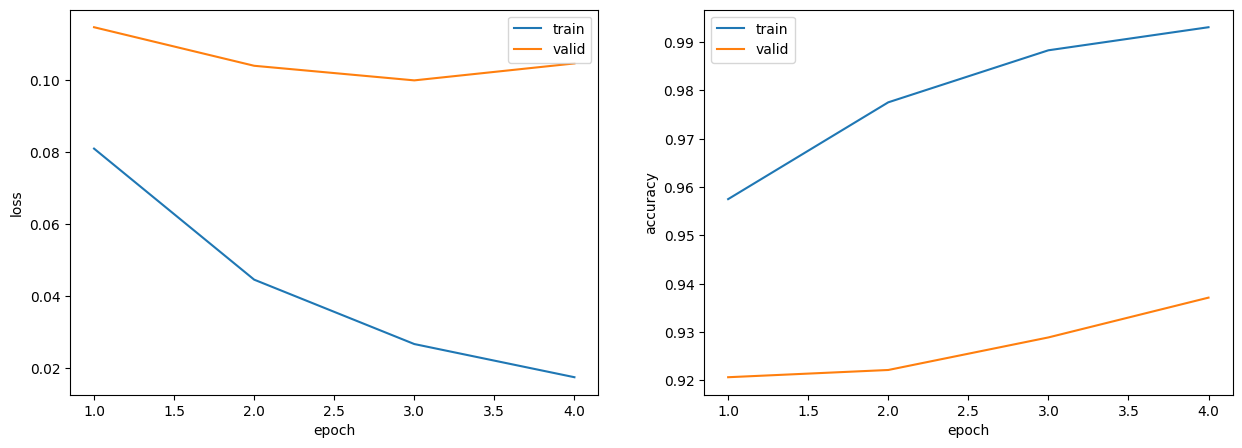

In [58]:
# ログの可視化
x_axis = [x for x in range(1, len(log['train']) + 1)]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(x_axis, np.array(log['train']).T[0], label='train')
ax[0].plot(x_axis, np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(x_axis, np.array(log['train']).T[1], label='train')
ax[1].plot(x_axis, np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [59]:
# 正解率の算出
def calculate_accuracy(model, dataset, device):
  # Dataloaderの作成
  loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for data in loader:
      # デバイスの指定
      ids = data['ids'].to(device)
      mask = data['mask'].to(device)
      labels = data['labels'].to(device)

      # 順伝播 + 予測値の取得 + 正解数のカウント
      outputs = model.forward(ids, mask)
      pred = torch.argmax(outputs, dim=-1).cpu().numpy()
      labels = torch.argmax(labels, dim=-1).cpu().numpy()
      total += len(labels)
      correct += (pred == labels).sum().item()

  return correct / total

print(f'正解率（学習データ）：{calculate_accuracy(model, dataset_train, device):.3f}')
print(f'正解率（検証データ）：{calculate_accuracy(model, dataset_valid, device):.3f}')
print(f'正解率（評価データ）：{calculate_accuracy(model, dataset_test, device):.3f}')

正解率（学習データ）：0.993
正解率（検証データ）：0.937
正解率（評価データ）：0.951
